In [26]:
import torch
import torchvision.transforms as transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [27]:
# Check PyTorch version
print(f"PyTorch Version: {torch.__version__}")

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


PyTorch Version: 2.4.0+cu124
Using device: cuda


In [29]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# Directory paths
train_dir = "C:/Deep Fake Image Detector/Dataset Initial/train"
val_dir = "C:/Deep Fake Image Detector/Dataset Initial/valid"
test_dir = "C:/Deep Fake Image Detector/Dataset Initial/test"

# Defining transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Loading datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

# Creating dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

# Printing dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(f"Training set size: {dataset_sizes['train']}")
print(f"Validation set size: {dataset_sizes['val']}")
print(f"Test set size: {dataset_sizes['test']}")


Training set size: 10000
Validation set size: 2000
Test set size: 2000


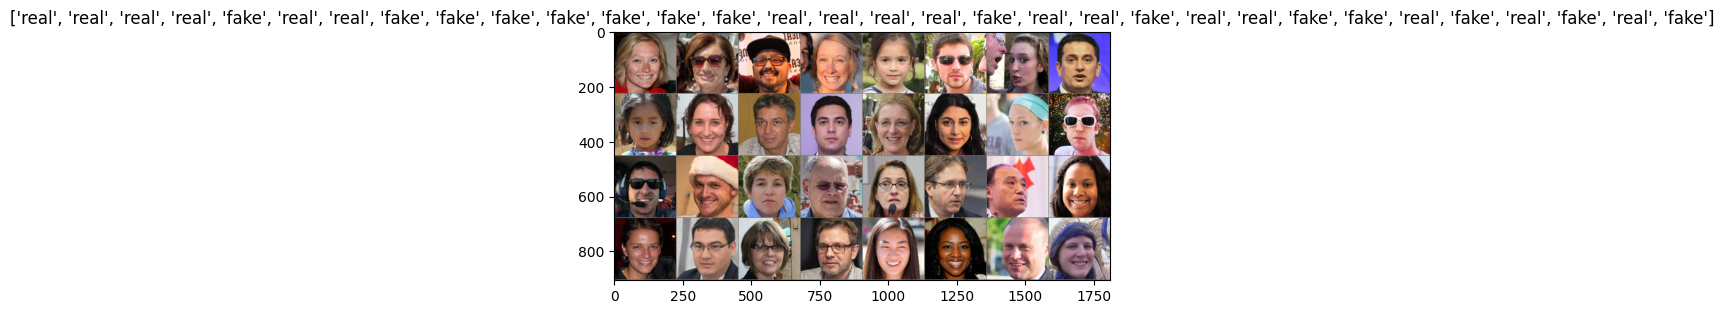

In [30]:
import matplotlib.pyplot as plt
import torchvision

# Function to display a batch of images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pausing so that plots are updated

# Getting a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Making a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[image_datasets['train'].classes[x] for x in classes])


In [31]:
#Augmentation
import torchvision.transforms.functional as F
import random

# Defining a custom CutMix transformation
class CutMix(object):
    def __init__(self, beta=1.0, prob=0.5):
        self.beta = beta
        self.prob = prob

    def __call__(self, img, target):
        if random.random() < self.prob:
            lam = np.random.beta(self.beta, self.beta)
            rand_index = torch.randperm(img.size(0))
            target_a = target
            target_b = target[rand_index]
            bbx1, bby1, bbx2, bby2 = self.rand_bbox(img.size(), lam)
            img[:, :, bbx1:bbx2, bby1:bby2] = img[rand_index, :, bbx1:bbx2, bby1:bby2]
            return img, target_a, target_b, lam
        else:
            return img, target, target, 1.0

    def rand_bbox(self, size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = np.int(W * cut_rat)
        cut_h = np.int(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        
        return bbx1, bby1, bbx2, bby2

# Defining a custom Random Erasing transformation
class RandomErasing(object):
    def __init__(self, probability=0.5, sl=0.02, sh=0.4, r1=0.3):
        self.probability = probability
        self.sl = sl
        self.sh = sh
        self.r1 = r1

    def __call__(self, img):
        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]

            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(np.sqrt(target_area * aspect_ratio)))
            w = int(round(np.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                img[:, x1:x1+h, y1:y1+w] = torch.randn((img.size()[0], h, w)) * 0.5
                return img

        return img

# Augmentations included in the preprocessing pipeline
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([CutMix(), RandomErasing()], p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [32]:
# Error Level Analysis (ELA)
def error_level_analysis(img, scale=10):
    img.save('temp.jpg', 'JPEG', quality=90)
    temp_img = Image.open('temp.jpg')
    ela_img = ImageChops.difference(img, temp_img)
    extrema = ela_img.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)
    return ela_img

# useage ELA in preprocessing
def ela_preprocess(img_path):
    img = Image.open(img_path)
    ela_img = error_level_analysis(img)
    return ela_img


In [33]:
# resizing images to multiple resolutions
multi_res_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# creating image pyramids
def create_image_pyramid(img, levels=3):
    pyramid = [img]
    for i in range(1, levels):
        resized_img = img.resize((img.size[0] // (2**i), img.size[1] // (2**i)), Image.ANTIALIAS)
        pyramid.append(resized_img)
    return pyramid

In [34]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to balance the dataset
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    return X_res, y_res


In [35]:
import torch
import torch.nn as nn
import timm

# Loading the pre-trained Vision Transformer model
class DeepfakeDetectionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepfakeDetectionModel, self).__init__()
        # Load a pre-trained ViT model from timm
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        # Replace the classifier head
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

# Initializing the model
model = DeepfakeDetectionModel(num_classes=2)

# Moving the model to the GPU if available
model = model.to(device)


In [36]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [37]:
import os

def train_model_with_checkpoints(model, criterion, optimizer, dataloaders, num_epochs=25, checkpoint_dir='checkpoints'):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Creating the checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the model if it has the best accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

            # Saving a checkpoint at the end of each epoch
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                'accuracy': epoch_acc,
                'best_accuracy': best_acc,
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
            torch.save(checkpoint, checkpoint_path)
            print(f'Model checkpoint saved at {checkpoint_path}')

        print()

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model

# Training the model with checkpoints
model = train_model_with_checkpoints(model, criterion, optimizer, dataloaders, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.8700 Acc: 0.4914
Model checkpoint saved at checkpoints\checkpoint_epoch_0.pth
val Loss: 0.7044 Acc: 0.5000
Model checkpoint saved at checkpoints\checkpoint_epoch_0.pth

Epoch 1/24
----------
train Loss: 0.7179 Acc: 0.5070
Model checkpoint saved at checkpoints\checkpoint_epoch_1.pth
val Loss: 0.8794 Acc: 0.5000
Model checkpoint saved at checkpoints\checkpoint_epoch_1.pth

Epoch 2/24
----------
train Loss: 0.7070 Acc: 0.5050
Model checkpoint saved at checkpoints\checkpoint_epoch_2.pth
val Loss: 0.6900 Acc: 0.5405
Model checkpoint saved at checkpoints\checkpoint_epoch_2.pth

Epoch 3/24
----------
train Loss: 0.6922 Acc: 0.5258
Model checkpoint saved at checkpoints\checkpoint_epoch_3.pth
val Loss: 0.6974 Acc: 0.5000
Model checkpoint saved at checkpoints\checkpoint_epoch_3.pth

Epoch 4/24
----------
train Loss: 0.6890 Acc: 0.5416
Model checkpoint saved at checkpoints\checkpoint_epoch_4.pth
val Loss: 0.6791 Acc: 0.5685
Model checkpoint saved at checkpoints

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model_with_metrics(model, dataloader):
    model.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = running_corrects.double() / dataset_sizes['test']
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Calculating evaluation metrics
    precision = precision_score(all_labels, all_preds, pos_label=1)
    recall = recall_score(all_labels, all_preds, pos_label=1)
    f1 = f1_score(all_labels, all_preds, pos_label=1)
    auc = roc_auc_score(all_labels, all_preds)
    
    # Confusion Matrix to calculate False Positive Rate
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    
    print("Evaluation Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")

    print("\nConfusion Matrix:")
    print(cm)

# Evaluate the model on the test set with the new metrics
evaluate_model_with_metrics(model, dataloaders['test'])


Test Accuracy: 0.6355
Evaluation Metrics:
Precision: 0.6188
Recall: 0.7060
F1-score: 0.6595
AUC-ROC: 0.6355
False Positive Rate (FPR): 0.4350

Confusion Matrix:
[[565 435]
 [294 706]]


In [39]:
# Saving the trained model

model_save_path = "deepfake_detection_model.pth"

torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to deepfake_detection_model.pth
